# RF, LR data preprocessing

In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from imblearn.combine import SMOTETomek
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

nltk.download('stopwords')


stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taoxiyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv("/Users/taoxiyan/Downloads/job_classification/balanced_data_17.csv")
# data.set_index('job_id', inplace=True)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,1
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,1
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31753 entries, 0 to 31752
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               31753 non-null  int64 
 1   title                31753 non-null  object
 2   location             31103 non-null  object
 3   department           11710 non-null  object
 4   salary_range         6436 non-null   object
 5   company_profile      29032 non-null  object
 6   description          31753 non-null  object
 7   requirements         29212 non-null  object
 8   benefits             24907 non-null  object
 9   telecommuting        31753 non-null  int64 
 10  has_company_logo     31753 non-null  int64 
 11  has_questions        31753 non-null  int64 
 12  employment_type      24426 non-null  object
 13  required_experience  17743 non-null  object
 14  required_education   16415 non-null  object
 15  industry             22450 non-null  object
 16  func

In [4]:
data = data.replace(np.nan, '', regex=True)

In [5]:
data['text'] = data[['title', 'department','company_profile','description',
                     'requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1)

In [6]:
data.drop(['job_id', 'location','title','salary_range' ,'department','salary_range',
           'company_profile','description','requirements','benefits'], axis=1, inplace=True)

In [7]:
data.columns
data_columns = data.columns.tolist()

In [8]:
from sklearn.preprocessing import LabelEncoder
label_columns = ['employment_type','required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
  data[i] = lb_make.fit_transform(data[i])

In [9]:
data_columns = data_columns[-1:] + data_columns[:-1]
data = data[data_columns]
data.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label
0,"Marketing Intern Marketing We're Food52, and w...",0,1,0,3,5,0,0,23,0,0
1,Customer Service - Cloud Video Production Succ...,0,1,0,2,7,0,76,8,0,1
2,Commissioning Machinery Assistant (CMA) Valor...,0,1,0,0,0,0,0,0,0,1
3,Account Executive - Washington DC Sales Our pa...,0,1,0,2,6,2,23,32,0,0
4,Bill Review Manager SpotSource Solutions LLC ...,0,1,1,2,6,2,52,17,0,0


In [10]:
print(data.iloc[1].at['text'])


Customer Service - Cloud Video Production Success 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, 

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [12]:
## Defining the utility functions

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+|url\S+|URL\S+')
    return url.sub(r'',str(text))


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text))


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',str(text))


def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def final_preprocess(text):
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
    text = text.lower()
    ps = PorterStemmer()
    text = ps.stem(text)
    return text

In [13]:
data['text']=data['text'].map(remove_URL)
data['text']=data['text'].map(remove_emoji)
data['text']=data['text'].map(remove_html)
data['text']=data['text'].map(remove_punctuation)
data['text']=data['text'].map(decontracted)
data['text']=data['text'].map(final_preprocess)
print(data.iloc[1].at['text'])

customer service cloud video production success 90 seconds worlds cloud video production service90 seconds worlds cloud video production service enabling brands agencies get high quality online video content shot produced anywhere world 90 seconds makes video production fast affordable managed seamlessly cloud purchase publish seconds removes hassle cost risk speed issues working regular video production companies managing every aspect video projects beautiful online experience growing global network 2000 rated video professionals 50 countries managed dedicated production success teams 5 countries 90 seconds provides 100 success guarantee90 seconds produced almost 4000 videos 30 countries 500 global brands including worlds largest including paypal l oreal sony barclays offices auckland london sydney tokyo singapore organised focused vibrant awesomedo passion customer service slick typing skills maybe account management think administration cooler polar bear jetski need hear cloud video

In [15]:
data.head

<bound method NDFrame.head of                                                     text  telecommuting  \
0      marketing intern marketing food52 weve created...              0   
1      customer service cloud video production succes...              0   
2      commissioning machinery assistant cma valor se...              0   
3      account executive washington dc sales passion ...              0   
4      bill review manager spotsource solutions llc g...              0   
...                                                  ...            ...   
31748  web application developers engineering vend lo...              0   
31749  web application developers engineering vend lo...              0   
31750  web application developers engineering vend lo...              0   
31751  web application developers engineering peddle ...              0   
31752  web application developers engineering vend lo...              0   

       has_company_logo  has_questions  employment_type  required_exp

In [16]:
data.to_csv('/Users/taoxiyan/Downloads/job_classification/mldatacleaning.csv')

In [17]:
## Making a dictionary of the words and their vector representation

embeddings_index = {}
f = open('/Users/taoxiyan/Downloads/job_classification/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

In [18]:
glove_words =  set(embeddings_index.keys())

'''
Below is a uliity function that takes sentenes as a input and return the vector representation of the same
Method adopted is similar to average word2vec. Where i am summing up all the vector representation of the words from the glove and 
then taking the average by dividing with the number of words involved
'''

def convert_sen_to_vec(sentence):
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split():
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector

In [19]:
converted_data = []

for i in range(0, data.shape[0]):
    converted_data.append(convert_sen_to_vec(data['text'][i]))

# data['text'] = data['text'].apply(lambda x : convert_sen_to_vec(x))
# converted_data = data['text']

# df1 = pd.DataFrame(converted_data)
# #data.drop(["text"], axis=1, inplace=True)
# main_data = pd.concat([df1,data], axis=1)

_1 = pd.DataFrame(converted_data)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data[['required_education', 'required_experience', 'employment_type', 'industry', 'function']] = StandardScaler().fit_transform(data[['required_education', 'required_experience', 'employment_type', 'industry', 'function']])


In [21]:
data.drop(["text"], axis=1, inplace=True)
main_data = pd.concat([_1,data], axis=1)

In [22]:
main_data.head()

,0,1,2,3,4,5,6,7,8,9,...,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,label
0,-0.060872,0.035633,0.019919,-0.041460,-0.031277,0.134662,0.068764,-0.135131,0.108838,1.667150,...,0,1,0,1.247047,1.048315,-0.765538,-1.070694,1.275624,0,0
1,-0.098752,0.136833,-0.018848,-0.085950,0.083228,-0.028549,-0.017753,-0.078328,0.056169,1.856209,...,0,1,0,0.334389,1.826542,-0.765538,0.967933,-0.139875,0,1
2,0.001197,-0.013580,0.067971,-0.034328,0.052963,-0.021067,0.049844,-0.033311,-0.022467,2.069530,...,0,1,0,-1.490926,-0.897255,-0.765538,-1.070694,-0.894808,0,1
3,-0.129031,0.151815,0.010966,-0.069932,0.076066,0.005172,0.001917,0.063714,0.068870,2.066986,...,0,1,0,0.334389,1.437429,-0.114448,-0.453741,2.124923,0,0
4,-0.127992,0.131819,0.038686,-0.052916,0.006336,0.000911,0.050824,-0.047775,0.101222,2.059116,...,0,1,1,0.334389,1.437429,-0.114448,0.324156,0.709424,0,0


# train&test 

In [23]:
train = pd.DataFrame(main_data)
test = pd.DataFrame(main_data)

In [24]:
from tqdm import tqdm
import numpy as np 
import pandas as pd

# train = pd.DataFrame(data)

for i in tqdm(range(train.index.max())):
    if train.loc[i,'label']==1:
        train.drop([i],inplace=True)
print(len(train))

100%|██████████| 31752/31752 [01:05<00:00, 486.89it/s]

28430


In [25]:
from tqdm import tqdm
import numpy as np 
import pandas as pd

# train = pd.DataFrame(data)

for i in tqdm(range(test.index.max())):
    if test.loc[i,'label']==0:
        test.drop([i],inplace=True)
print(len(test))

100%|██████████| 31752/31752 [05:22<00:00, 98.41it/s] 

3324


In [26]:
train.drop(['label'], axis=1, inplace=True)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,299,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,-0.060872,0.035633,0.019919,-0.041460,-0.031277,0.134662,0.068764,-0.135131,0.108838,1.667150,...,0.077385,0,1,0,1.247047,1.048315,-0.765538,-1.070694,1.275624,0
3,-0.129031,0.151815,0.010966,-0.069932,0.076066,0.005172,0.001917,0.063714,0.068870,2.066986,...,0.081964,0,1,0,0.334389,1.437429,-0.114448,-0.453741,2.124923,0
4,-0.127992,0.131819,0.038686,-0.052916,0.006336,0.000911,0.050824,-0.047775,0.101222,2.059116,...,0.003380,0,1,1,0.334389,1.437429,-0.114448,0.324156,0.709424,0
5,-0.106577,0.099312,0.031362,-0.096781,0.087146,-0.030393,0.008387,0.007971,0.052128,2.152144,...,-0.005407,0,0,0,-1.490926,-0.897255,-0.765538,-1.070694,-0.894808,0
6,-0.034404,0.150401,0.014151,0.006244,0.073341,0.013696,0.046625,-0.026552,0.096019,1.895589,...,0.115523,0,1,1,0.334389,1.437429,1.187732,1.343470,1.086890,0


In [27]:
test.drop(['label'], axis=1, inplace=True)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,299,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
1,-0.098752,0.136833,-0.018848,-0.085950,0.083228,-0.028549,-0.017753,-0.078328,0.056169,1.856209,...,0.151440,0,1,0,0.334389,1.826542,-0.765538,0.967933,-0.139875,0
2,0.001197,-0.013580,0.067971,-0.034328,0.052963,-0.021067,0.049844,-0.033311,-0.022467,2.069530,...,0.026573,0,1,0,-1.490926,-0.897255,-0.765538,-1.070694,-0.894808,0
19,-0.040510,0.056530,0.016855,-0.044821,0.028809,-0.003864,-0.027677,-0.061588,0.008062,1.791237,...,0.012405,0,0,0,0.334389,-0.897255,-0.765538,-1.070694,-0.894808,0
28,-0.116778,0.150707,-0.047210,0.001689,-0.021513,0.091424,-0.002303,0.001875,0.064290,1.968698,...,0.048308,0,0,0,0.334389,-0.897255,-0.765538,0.887461,-0.894808,0
29,-0.147590,0.154365,-0.057021,-0.096300,-0.025584,-0.008118,-0.026656,-0.114135,0.022954,1.838514,...,0.046454,0,1,0,0.334389,0.270087,0.862187,-0.346445,-0.706075,0


In [28]:
X = train.iloc[:, :-1]
Y = train.iloc[:, -1]
print(len(X),len(Y))

X_test = test.iloc[:, :-1]
Y_test = test.iloc[:, -1]
print(len(X_test),len(Y_test))

# RF: Modelling and Measuring performance with F1 Score(Using XgBoost)
不知道是训练太慢了还是咋 我跑不出结果。。。

In [45]:
# ## Lets build our hyperparameter search grid
# ## since we have a large space of hyperparamter we will use randomisedSearchCV


# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 800, num = 5)]

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}


# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 4,scoring = 'f1')
# rf_random.fit(X, Y)

In [ ]:
# # Model (can also use single decision tree)
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=10)

# # Train
# model.fit(iris.data, iris.target)
# # Extract single tree
# estimator = model.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


In [ ]:
# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [ ]:
# print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
# print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

# LR: Modelling and Measuring performance with F1 Score(Using XgBoost)

In [33]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(C=1)  # 默认使用L2正则化避免过拟合，C=1.0表示正则力度(超参数，可以调参调优)
lg.fit(X,Y)
 
# 回归系数
print(lg.coef_)  # 
 
# 进行预测
y_predict = lg.predict(X_test)
 
print("precision：", lg.score(X_test, Y_test))  # 
 
print("recall：", classification_report(Y_test, y_predict, labels=[1, 0], target_names=["F", "R"]))



[[-5.25982926e+00 -1.42255577e+00 -3.42045562e+00  1.78119183e+00
   1.70403647e+00  1.66908841e+00  1.15047553e+00 -1.30604955e-01
  -2.55987493e+00  2.62480780e+00 -2.59515172e+00 -2.82114581e+00
  -2.22152989e+00 -1.36987860e+00  1.04966271e+00 -5.65398417e+00
  -3.46962646e+00 -5.19759664e-01 -1.21570274e+00  2.09338389e+00
   1.12922133e+00  2.86594476e+00  7.55067877e-01  4.03733174e+00
   2.97684191e+00 -1.64321153e+00 -7.01982515e-01  1.82214740e+00
  -1.87052438e+00 -2.03603604e-01 -4.82836171e-01 -9.11383355e-01
   6.73539540e-01  7.18051331e-01 -2.41778139e+00 -2.22742540e+00
   1.85371175e+00  1.54555023e+00 -6.36007989e+00 -2.99935380e+00
  -2.54053479e+00 -1.94540541e+00 -2.14205203e+00 -3.32005757e+00
   7.36819941e-01 -1.40227102e+00  1.56353029e+00  2.67375403e+00
   1.17698240e+00  2.08603784e+00  4.59355084e+00  2.46041710e+00
  -2.33685534e+00  2.26357184e+00 -1.52211234e+00 -3.97904998e+00
   2.71095595e+00  1.47835888e+00 -5.99694368e+00 -3.32690486e+00
  -5.64698

/Users/taoxiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Gaussin NB

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X, Y).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" %(X_test.shape[0], (Y_test != y_pred).sum()))
print("nb accuracy:",gnb.score(y_pred.reshape(-1,1),Y_test))

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3) # n_neighbors = k
knn.fit(X,Y)
prediction = knn.predict(X_test)
print(" {} knn score: {} ".format(3,knn.score(X_test,Y_test)))

# NB: Modelling and Measuring performance with F1 Score(Using XgBoost)

In [3]:
data=pd.read_csv('/Users/taoxiyan/Downloads/job_classification/mldatacleaning.csv')

In [4]:
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [5]:
from wordcloud import WordCloud,STOPWORDS

In [8]:
from tqdm import tqdm
cleaned_title = []

for sentance in tqdm(data['text'].values):
    sentance = str(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    cleaned_title.append(sentance.strip())
data['text'] = cleaned_title
data.head

100%|██████████| 31753/31753 [00:08<00:00, 3749.02it/s]


<bound method NDFrame.head of        Unnamed: 0                                               text  \
0               0  marketing intern marketing  weve created groun...   
1               1  customer service cloud video production succes...   
2               2  commissioning machinery assistant cma valor se...   
3               3  account executive washington dc sales passion ...   
4               4  bill review manager spotsource solutions llc g...   
...           ...                                                ...   
31748       31748  web application developers engineering vend lo...   
31749       31749  web application developers engineering vend lo...   
31750       31750  web application developers engineering vend lo...   
31751       31751  web application developers engineering peddle ...   
31752       31752  web application developers engineering vend lo...   

       telecommuting  has_company_logo  has_questions  employment_type  \
0                  0           

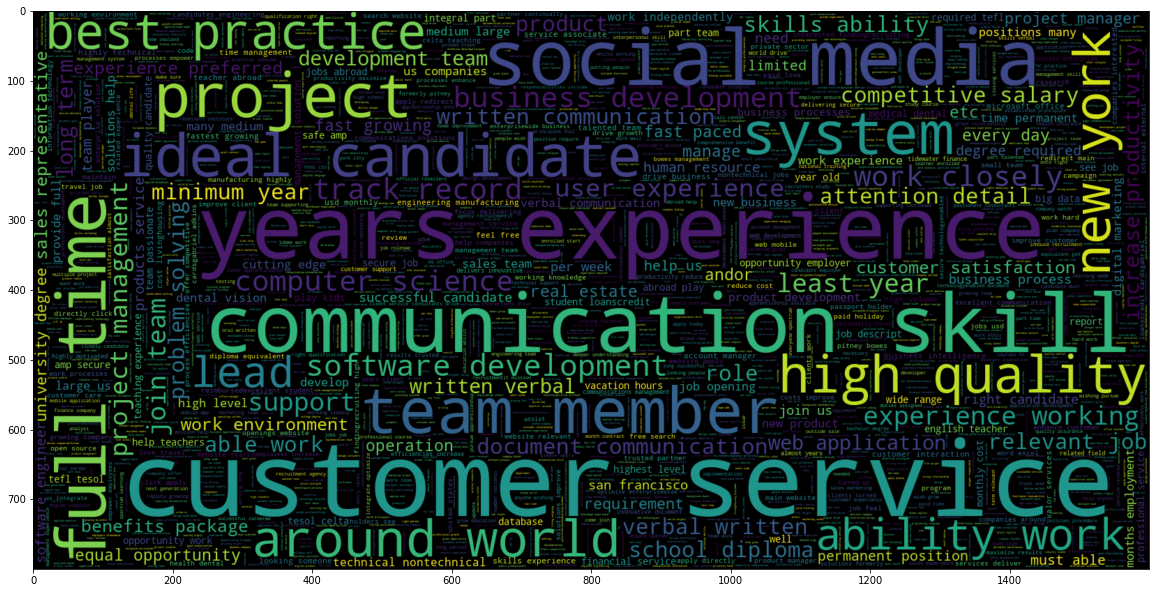

In [9]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(data[data.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

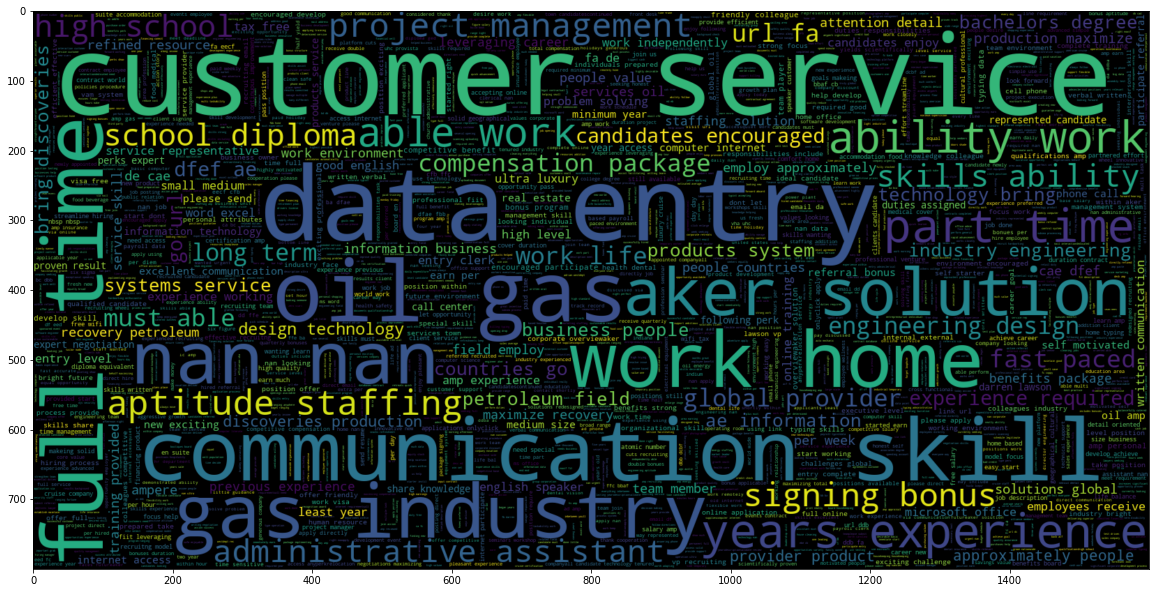

In [10]:
plt.figure(figsize = (20,20)) # Text that is  fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(data[data.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

divide test & train

In [11]:
train = pd.DataFrame(data)
test = pd.DataFrame(data)

from tqdm import tqdm
import numpy as np 
import pandas as pd

# train = pd.DataFrame(data)

for i in tqdm(range(train.index.max())):
    if train.loc[i,'label']==1:
        train.drop([i],inplace=True)
print(len(train))

100%|██████████| 31752/31752 [00:12<00:00, 2473.44it/s]

28430


In [12]:
from tqdm import tqdm
import numpy as np 
import pandas as pd

# train = pd.DataFrame(data)

for i in tqdm(range(test.index.max())):
    if test.loc[i,'label']==0:
        test.drop([i],inplace=True)
print(len(test))

100%|██████████| 31752/31752 [00:48<00:00, 654.26it/s] 

3324


In [13]:
train.drop(['label','Unnamed: 0','employment_type','required_experience', 'required_education', 'industry', 'function'], axis=1, inplace=True)
train.head()

,text,telecommuting,has_company_logo,has_questions,fraudulent
0,marketing intern marketing weve created groun...,0,1,0,0
3,account executive washington dc sales passion ...,0,1,0,0
4,bill review manager spotsource solutions llc g...,0,1,1,0
5,accounting clerk job overviewapex environmenta...,0,0,0,0
6,head content mf androidpit founded fonpit ag ...,0,1,1,0


In [14]:
test.drop(['label','Unnamed: 0','employment_type','required_experience', 'required_education', 'industry', 'function'], axis=1, inplace=True)
test.head()

,text,telecommuting,has_company_logo,has_questions,fraudulent
1,customer service cloud video production succes...,0,1,0,0
2,commissioning machinery assistant cma valor se...,0,1,0,0
19,process controls engineer dcs plc ms office pa...,0,0,0,0
28,talent management process manager provide full...,0,0,0,0
29,customer service associate novitex enterprise ...,0,1,0,0


In [15]:
test.drop(['telecommuting','has_company_logo','has_questions'], axis=1, inplace=True)
train.drop(['telecommuting','has_company_logo','has_questions'], axis=1, inplace=True)


In [16]:
test.head()

,text,fraudulent
1,customer service cloud video production succes...,0
2,commissioning machinery assistant cma valor se...,0
19,process controls engineer dcs plc ms office pa...,0
28,talent management process manager provide full...,0
29,customer service associate novitex enterprise ...,0


In [17]:
cleaned_title1 = []

for sentance in tqdm(train['text'].values):
    sentance = str(sentance)
    cleaned_title1.append(sentance.strip())
train['text'] = cleaned_title1
train.head

100%|██████████| 28430/28430 [00:00<00:00, 1454071.76it/s]


<bound method NDFrame.head of                                                     text  fraudulent
0      marketing intern marketing  weve created groun...           0
3      account executive washington dc sales passion ...           0
4      bill review manager spotsource solutions llc g...           0
5      accounting clerk job overviewapex environmenta...           0
6      head content mf androidpit founded  fonpit ag ...           0
...                                                  ...         ...
31748  web application developers engineering vend lo...           0
31749  web application developers engineering vend lo...           0
31750  web application developers engineering vend lo...           0
31751  web application developers engineering peddle ...           0
31752  web application developers engineering vend lo...           0

[28430 rows x 2 columns]>

In [18]:
cleaned_title2 = []

for sentance in tqdm(test['text'].values):
    sentance = str(sentance)
    cleaned_title2.append(sentance.strip())
test['text'] = cleaned_title2
test.head

100%|██████████| 3324/3324 [00:00<00:00, 1259996.97it/s]


<bound method NDFrame.head of                                                     text  fraudulent
1      customer service cloud video production succes...           0
2      commissioning machinery assistant cma valor se...           0
19     process controls engineer dcs plc ms office pa...           0
28     talent management process manager provide full...           0
29     customer service associate novitex enterprise ...           0
...                                                  ...         ...
31375  business opportunity ptft available nan demand...           1
31376  business opportunity ptft available nan demand...           1
31377  business opportunity ptft available nan demand...           1
31378  business opportunity ptft available nan demand...           1
31752  web application developers engineering vend lo...           0

[3324 rows x 2 columns]>

In [19]:
# a = np.array([[1],[2],[3]])
# c = []
# b=a.tolist()
# for i in a:
#     c.append(i[0])
# c = np.array(c)

# print(a.shape)
# # print(b.shape)
# print(c.shape)
# type(c.shape) #try change to tuple #tf-idf only receive () values

In [20]:
train1 = []
test1 = []
for i in train.text:
    train1.append(i)
# train1 = np.array(train1)

for i in test.text:
    test1.append(i)
test1 = np.array(test1)

print(test1.shape)

(3324,)


In [21]:
X = train1
Y = train.iloc[:, -1]
print(len(X),len(Y))

X_test = test1
Y_test = test.iloc[:, -1]
print(len(X_test),len(Y_test))

28430 28430
3324 3324


In [22]:
print(X_test)

['customer service cloud video production success  seconds worlds cloud video production  seconds worlds cloud video production service enabling brands agencies get high quality online video content shot produced anywhere world  seconds makes video production fast affordable managed seamlessly cloud purchase publish seconds removes hassle cost risk speed issues working regular video production companies managing every aspect video projects beautiful online experience growing global network  rated video professionals  countries managed dedicated production success teams  countries  seconds provides  success  seconds produced almost  videos  countries  global brands including worlds largest including paypal l oreal sony barclays offices auckland london sydney tokyo singapore organised focused vibrant awesomedo passion customer service slick typing skills maybe account management think administration cooler polar bear jetski need hear cloud video production service opperating glodal level

In [23]:
Y.head()

0    0
3    0
4    0
5    0
6    0
Name: fraudulent, dtype: int64

In [24]:
# X.shape

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_cross, y_train, y_cross = train_test_split(X, Y, random_state=0, stratify=Y, test_size=0.1)

In [26]:
# X_train=X_train.values.tolist()
# y_train=y_train.values.tolist()
# tuple(X_train)

In [27]:
# X_train.shape

In [248]:
# print(X_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_train_reviews.shape

(25587, 2206856)

In [29]:
tv_cross_reviews=tv.transform(X_cross)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_cross_reviews.shape)

tv_test_reviews=tv.transform(X_test)

Tfidf_train: (25587, 2206856)
Tfidf_test: (2843, 2206856)


# multi-NB

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
    naive_b=MultinomialNB(alpha=i)
    naive_b.fit(tv_train_reviews, y_train)
    Train_y_pred =  naive_b.predict(tv_train_reviews)
    Train_AUC_BOW.append(roc_auc_score(y_train,Train_y_pred))
    CrossVal_y_pred =  naive_b.predict(tv_cross_reviews)
    CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [32]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
    Alpha_set.append(math.log(alpha_set[i]))

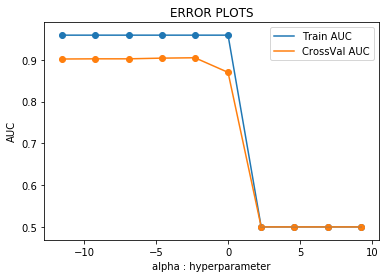

In [33]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [34]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print("optimal_alpha=",optimal_alpha)

optimal_alpha= 0.1


In [35]:
Classifier1=MultinomialNB(alpha=optimal_alpha)
Classifier1.fit(tv_train_reviews, y_train)

MultinomialNB(alpha=0.1)

In [36]:
auc_train_bow = roc_auc_score(y_train,Classifier1.predict(tv_train_reviews))
print ("AUC for Train set", auc_train_bow)

auc_test_bow = roc_auc_score(Y_test,Classifier1.predict(tv_test_reviews))
print ("AUC for Test set",auc_test_bow)

AUC for Train set 0.9588744588744589
AUC for Test set 0.798811013767209


In [43]:
from sklearn.metrics import accuracy_score, log_loss, f1_score

preds = Classifier1.predict(tv_test_reviews)

acc = accuracy_score(Y_test, preds)

f1 = f1_score(Y_test, preds, average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Y_test,preds)
print (Test_mat)

from sklearn import metrics
print(metrics.classification_report(Y_test, preds))

Accuracy is :  0.8023465703971119
F1 Score is : 0.7932016618728028
Confusion Matrix of Test Data
[[1683    9]
 [ 648  984]]
              precision    recall  f1-score   support

           0       0.72      0.99      0.84      1692
           1       0.99      0.60      0.75      1632

    accuracy                           0.80      3324
   macro avg       0.86      0.80      0.79      3324
weighted avg       0.85      0.80      0.79      3324

